In [62]:
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

%run ../JM_custom_figs.py
%run ../fx4roc.py

In [26]:
datafolder = "C:\\Github\\Distraction-Paper\\data\\"
figfolder = "C:\\Github\\Distraction-Paper\\figs\\"
outputfolder = "C:\\Github\\Distraction-Paper\\output\\"

try:
    pickle_in = open(datafolder + "distraction_data_only_snips.pickle", 'rb')
except FileNotFoundError:
        print('Cannot access pickled file')

[modDict, disDict, habDict] = dill.load(pickle_in)

try:
    pickle_in = open(outputfolder+"roc_results_licks", 'rb')
except FileNotFoundError:
        print('Cannot access pickled file')

[a, p] = dill.load(pickle_in)

In [27]:
rats = disDict.keys()
rat= 'thph1.2'
d = disDict[rat]
d.keys()

dict_keys(['rat', 'fs', 'tick', 'filt_sd', 'licks', 'licks_off', 'distractors', 'distracted', 'notdistracted', 'd_bool_array', 'pdp', 'pre_dp', 'lickdata', 'snips_distractors', 'snips_distracted', 'snips_not-distracted'])

In [28]:
# Makes lick snips for all distractors and then flattens (e.g. pools snips from all rats)

def make_lick_snips(d, pre=5, post=15):
    snips = []
    for dis in d['distractors']:
        snips.append([lick-dis for lick in d['licks'] if (lick-dis>-pre) and (lick-dis<post) ])
        
    return snips

all_lick_snips = []
for rat in rats:
    d = disDict[rat]
    all_lick_snips.append(make_lick_snips(d))

all_lick_snips_flat = flatten_list(all_lick_snips)

In [29]:
# This cell uses a simple function to check whether any licks occur between 0 and 1 seconds (i.e. is it a distracted snip or not)

def check_val_between(data, x1=0.001, x2=1.000):
    """ Checks if there is a value in a list between two numbers"""
    
    vals = [1 for d in data if d>x1 and d<x2]
    
    if sum(vals) > 0:
        return True
    else:
        return False
    
dis_snips = [snip for snip in all_lick_snips_flat if not check_val_between(snip)]
notdis_snips = [snip for snip in all_lick_snips_flat if check_val_between(snip)]

In [30]:
# Test to ensure that code using check_val_between is selecting correct number of distracted and non-distracted snips
number_of_distracted_snips=[]

for rat in rats:
    d = disDict[rat]
    number_of_distracted_snips.append(len(d['snips_distracted']['filt_z']))
sum(number_of_distracted_snips)

344

In [31]:
# turns snips into binned data

# bins = np.arange(-10, 20, 1)
bins = np.arange(-5, 15, 1)
dis_hist = [np.histogram(snip, bins=bins)[0] for snip in dis_snips]
notdis_hist = [np.histogram(snip, bins=bins)[0] for snip in notdis_snips]

In [32]:
# Cell to run ROC analysis - takes a while so commented out unless needed
import time
start_time = time.time()

a, p = nanroc(notdis_hist, dis_hist, n4shuf=2000)

print(f"--- Total ROC analysis took {(time.time() - start_time)} seconds ---")



Analysing column 0
Analysing column 1
Analysing column 2
Analysing column 3
Analysing column 4
Analysing column 5
Analysing column 6
Analysing column 7
Analysing column 8
Analysing column 9
Analysing column 10
Analysing column 11
Analysing column 12
Analysing column 13
Analysing column 14
Analysing column 15
Analysing column 16
Analysing column 17
Analysing column 18
--- Total ROC analysis took 207.96642017364502 seconds ---


In [33]:
savefile=True
if savefile:
    pickle_out = open(outputfolder+"roc_results_licks", 'wb')
    dill.dump([a, p], pickle_out)
    pickle_out.close()

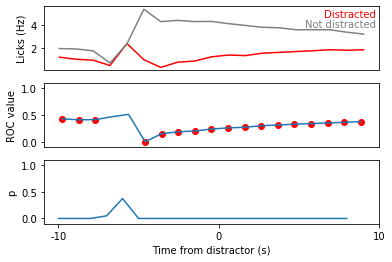

In [34]:
f, ax = plt.subplots(nrows=3)

ax[0].plot(np.mean(dis_hist, axis=0), color='red')
ax[0].plot(np.mean(notdis_hist, axis=0), color='grey')

ax[0].set_ylabel('Licks (Hz)')
ax[0].set_xticks([])

ax[0].text(0.99, 0.95, 'Distracted', color='red', ha='right', va='top', transform=ax[0].transAxes)
ax[0].text(0.99, 0.80, 'Not distracted', color='grey', ha='right', va='top', transform=ax[0].transAxes)

ax[1].plot(a)
ax[1].set_ylabel('ROC value')
ax[1].set_xticks([])

threshold = 0.05/len(p)
sigpoints = np.array([pval < threshold for pval in p], dtype=bool)

xdata = [x for x, L in zip(range(len(sigpoints)), sigpoints) if L]
ydata = logical_subset(a, sigpoints)
ax[1].scatter(xdata, ydata, color='red')

ax[1]. set_ylim([-0.1, 1.1])

ax[2].plot(p)
ax[2].set_ylim([-0.1, 1.1])
ax[2].set_ylabel('p')

ax[2].set_xticks([0, 10, 20])
ax[2].set_xticklabels(['-10', '0', '10'])
ax[2].set_xlabel('Time from distractor (s)')

# f.savefig(outputfolder + "licks_roc_analysis.png")


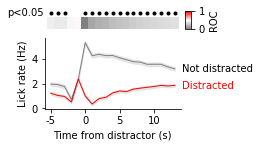

In [66]:
import matplotlib.gridspec as gridspec

f = plt.figure(figsize=(3.4,2))

gs=gridspec.GridSpec(2,2, figure=f, height_ratios=[0.25, 1], width_ratios=[1, 0.05], wspace=0.05,
                    bottom=0.2, right=0.75, left=0.15)

ax[0] = f.add_subplot(gs[0, 0])

# Creates colormap for ROC
cdict=['grey', 'white', 'red']
heatmap_color_scheme = LinearSegmentedColormap.from_list('rocmap', cdict)

roc_for_plot = a
xvals=np.arange(-0.5,19.)
yvals=[1, 2]
xx, yy = np.meshgrid(xvals, yvals)
    
mesh = ax[0].pcolormesh(xx, yy, [roc_for_plot, roc_for_plot], cmap=heatmap_color_scheme, shading = 'flat')
mesh.set_clim([0, 1])


xdata = [x for x, L in zip(range(len(sigpoints)), sigpoints) if L]
ydata = logical_subset(a, sigpoints)
ax[0].scatter(xdata, [2.5]*len(xdata), color='k', marker='.', clip_on=False)
ax[0].text(-1, 2.5, 'p<0.05', va='center', ha='right')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].set_xticks([])
ax[0].set_yticks([])

cbar_ax = f.add_subplot(gs[0,1])   
cbar = f.colorbar(mesh, cax=cbar_ax, ticks=[0, 1], label='ROC')

ax[1] = f.add_subplot(gs[1, 0])

shadedError(ax[1], notdis_hist, linecolor='grey')
shadedError(ax[1], dis_hist, linecolor='red')

ax[1].set_ylabel('Lick rate (Hz)')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# ax[1].set_xticks([0, 10, 20])
# ax[1].set_xticklabels(['-10', '0', '10'])
# ax[1].set_xlabel('Time from distractor (s)')

ax[1].set_xticks([0, 5, 10, 15])
ax[1].set_xticklabels(['-5', '0', '5', '10'])
ax[1].set_xlabel('Time from distractor (s)')

ax[1].text(19, np.mean(dis_hist, axis=0)[-1], 'Distracted', color='red', ha='left', va='center')
ax[1].text(19, np.mean(notdis_hist, axis=0)[-1], 'Not distracted', ha='left', va='center')

ax[0].set_xlim(ax[1].get_xlim())

f.savefig(figfolder+"fig3_roc-lickrate.pdf")




In [40]:

pre_lickrate_dis, pre_lickrate_notdis = [], []
post_lickrate_dis, post_lickrate_notdis = [], []

for snips in all_lick_snips:
    
    pre_dis, pre_notdis = [], []
    post_dis, post_notdis = [], []
    
    for snip in snips:
        
        nlicks_before_distractor = len([lick for lick in snip if lick<0])
        nlicks_after_distractor = len([lick for lick in snip if lick>1])
        
        if check_val_between(snip):
            pre_notdis.append(nlicks_before_distractor)
            post_notdis.append(nlicks_after_distractor)
        else:
            pre_dis.append(nlicks_before_distractor)
            post_dis.append(nlicks_after_distractor)

    pre_lickrate_dis.append(np.mean(pre_dis)/10) # dividing by 10 puts this into Hz as a 10s predistractor period is used
    pre_lickrate_notdis.append(np.mean(pre_notdis)/10)
    
    post_lickrate_dis.append(np.mean(post_dis)/10)
    post_lickrate_notdis.append(np.mean(post_notdis)/10)



Pre distractor 2.626631250085044 0.020920903320542816
Post distractor 7.614424692690707 3.82409586364871e-06


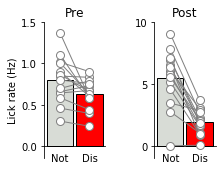

In [47]:
       
f, ax = plt.subplots(figsize=(3.4,2.5), ncols=2)
f.subplots_adjust(left=0.2, wspace=0.8)

barscatter([pre_lickrate_notdis, pre_lickrate_dis], paired=True,
           barfacecolor=['xkcd:light grey', 'red'], barfacecoloroption='individual',
           ax=ax[0])

barscatter([post_lickrate_notdis, post_lickrate_dis], paired=True,
           barfacecolor=['xkcd:light grey', 'red'], barfacecoloroption='individual',
           ax=ax[1])

for axis in ax:
    axis.set_xticks([1,2])
    axis.set_xticklabels(['Not', 'Dis'])
#     axis.set_xticks([])
    
ax[0].set_ylabel('Lick rate (Hz)')
ax[0].set_yticks([0, 0.5, 1, 1.5])
ax[0].set_ylim([-0.15, 1.5])
ax[0].set_title('Pre')

# ax[1].set_ylabel('Mean post-distractor lick rate (Hz)')
ax[1].set_yticks([0, 5, 10])
ax[1].set_ylim([-1, 10])
ax[1].set_title('Post')

f.savefig(figfolder+"fig3_predistractor-lickrate.pdf")

from scipy import stats

t, p = stats.ttest_rel(pre_lickrate_notdis, pre_lickrate_dis)
print('Pre distractor', t, p)

t, p = stats.ttest_rel(post_lickrate_notdis, post_lickrate_dis)
print('Post distractor', t, p)

# Note on time taken to run ROC analysis

On 19 Feb 2020 ran tests to see if ROC analysis was quicker running outside of Notebook.

Running inside Notebook took <u>413s</u>.

<b>(1)</b> Used the magic command to pass arguments to separate script

    %run ../run_roc_analysis.py "hist_licks" dis_hist notdis_hist 5 "roc_results_licks"

Results show 409s (i.e. no different to running in Notebook).

<b>(2)</b> Tried running completely separately within Spyder but outside Notebook (411 s)

<b>(3)</b> Tried running from a command prompt

    python run_roc_analysis.py
   
Took 389s so marginally faster but not a huge difference. Conclusion is to continue running within notebook. Will save [a, p] for easy analysis.


NB for (2) also necessary to run the following lines:

    pickle_out = open("hist_licks", 'wb')
    dill.dump([dis_hist, notdis_hist], pickle_out)
    pickle_out.close()
    
NB2 Later speeded up the code by ~100x by vectorizing using Numpy functions rather than inbuilt Python methods


<BarContainer object of 59 artists>

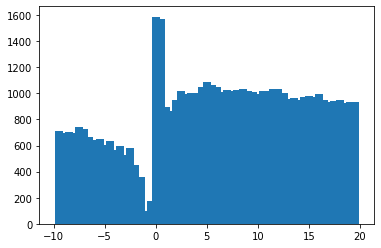

In [30]:
bins = np.arange(-10, 20, 0.5)
data = np.histogram(flatten_list(flatten_list(all_lick_snips)), bins=bins)

plt.bar(data[1][1:], data[0])